<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [154]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [155]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [156]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [157]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]

In [158]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [159]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [160]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [161]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [162]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
471170,3,2,4,6.0,36.988203,3.304824,39.0,8.6,6.9,78333.33333,78333.33333,2,33387803000,7406724000,18628484000,54.077921,-2.751931,270000.0
875831,3,1,3,4.0,53.609675,2.700129,17.0,11.8,10.6,150250.00000,150250.00000,1,9157894000,27232011000,15884538000,51.100951,-1.308008,132000.0
32100,2,2,2,9.0,88.017397,1.416920,9.0,11.6,10.2,100750.00000,111666.66670,11,4413698000,22185383000,13104884000,51.908753,-0.224303,270000.0
801282,3,2,2,12.0,87.712617,0.323960,29.0,9.7,8.6,52237.50000,50500.00000,13,38748796000,16428009000,26997661000,54.899429,-1.544099,100000.0
276257,2,1,1,71.0,129.544799,0.118934,62.0,8.8,7.0,365000.00000,201666.66670,10,1004647000,26381221000,16630053000,51.532924,-0.025923,480000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169380,2,2,2,7.0,104.746282,0.785241,34.0,7.7,6.3,63125.00000,58650.00000,24,11004875000,35509855000,26606455900,51.136437,1.296727,131500.0
893396,4,2,4,4.0,93.905697,1.294033,30.0,10.0,8.1,79000.00000,80750.00000,18,26589824900,34084844000,24719252000,50.537000,-3.638678,375000.0
195748,2,2,4,3.0,84.884162,0.910862,21.0,8.2,7.7,61583.33333,66000.00000,13,15593823000,10458140000,4732529000,52.721580,-1.327333,167000.0
52600,2,2,2,5.0,42.876036,0.818436,14.0,10.4,9.7,89983.33333,97500.00000,7,28265287000,5657814000,15577784000,53.877030,-1.711635,201610.0


In [163]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '4', ..., 54.077920999999996, -2.7519310000000003,
        270000.0],
       [3, '1', '3', ..., 51.100951, -1.308008, 132000.0],
       [2, '2', '2', ..., 51.908753000000004, -0.22430300000000003,
        270000.0],
       ...,
       [2, '2', '4', ..., 52.72158, -1.327333, 167000.0],
       [2, '2', '2', ..., 53.877030000000005, -1.7116349999999998,
        201610.0],
       [2, '2', '2', ..., 52.513692000000006, -1.481933, 126000.0]],
      dtype=object)

In [164]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [165]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [166]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [167]:
from sklearn import preprocessing

In [168]:
min_max_scaler = preprocessing.MinMaxScaler()

In [169]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 1.        , ..., 0.49486315, 0.70544771,
        0.39562688],
       [0.5       , 0.        , 0.66666667, ..., 0.42170485, 0.1923031 ,
        0.58918398],
       [0.25      , 1.        , 0.33333333, ..., 0.34759451, 0.33154509,
        0.73445405],
       ...,
       [0.25      , 1.        , 1.        , ..., 0.12437319, 0.47165326,
        0.58659347],
       [0.25      , 1.        , 0.33333333, ..., 0.41352627, 0.67081984,
        0.535078  ],
       [0.25      , 1.        , 0.33333333, ..., 0.07522051, 0.4358193 ,
        0.56586943]])

In [170]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [171]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [172]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [173]:
from sklearn.model_selection import train_test_split

In [174]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [175]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(718253, 17) (307824, 17) (718253,) (307824,)


In [176]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [177]:
model = Sequential([
    Dense(500, activation='relu', input_shape=X1_train.shape[1:]),
    Dense(1)
])

In [178]:
my_optimizer = keras.optimizers.Adam(learning_rate=0.009)
model.compile(
              loss='mean_squared_error',
               optimizer=my_optimizer)

In [179]:
import numpy as np

In [180]:
X1_train = np.asarray(X1_train).astype('float32')

In [181]:
Y1_train = np.asarray(Y1_train).astype('float32')

In [182]:
X1_test = np.asarray(X1_test).astype('float32')
Y1_test = np.asarray(Y1_test).astype('float32')

In [183]:
hist = model.fit(X1_train, Y1_train,
          epochs=100,
          validation_data=(X1_test, Y1_test))

Epoch 1/100
22446/22446 [==============================] - 45s 2ms/step - loss: 22489217964.3812 - val_loss: 7055105536.0000
Epoch 2/100
22446/22446 [==============================] - 43s 2ms/step - loss: 6745321496.6112 - val_loss: 5829784064.0000
Epoch 3/100
22446/22446 [==============================] - 44s 2ms/step - loss: 5652931300.9140 - val_loss: 5287116288.0000
Epoch 4/100
22446/22446 [==============================] - 44s 2ms/step - loss: 5184628183.4565 - val_loss: 5106684928.0000
Epoch 5/100
22446/22446 [==============================] - 43s 2ms/step - loss: 5019096926.7156 - val_loss: 5046221312.0000
Epoch 6/100
22446/22446 [==============================] - 43s 2ms/step - loss: 4935621783.0887 - val_loss: 5012231168.0000
Epoch 7/100
22446/22446 [==============================] - 45s 2ms/step - loss: 4907382968.1508 - val_loss: 4989546496.0000
Epoch 8/100
22446/22446 [==============================] - 44s 2ms/step - loss: 4889440556.0789 - val_loss: 4968554496.0000
Epoch 9

In [184]:
prediction1=model.predict(X1_test)
#print(prediction1)

In [185]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,4.0,2.0,4.0,4.000000,33.722023,1.738057,16.0,10.999999,9.599999,186750.000000,186750.000000,2.000000,4.700310e+09,2.770318e+10,1.678236e+10,51.198006,-0.618349,750000.0,743953.250000,6046.750000,3.656318e+07,6046.749871,47003100_277031834_167823606
1,4.0,2.0,4.0,12.999999,85.085426,1.366914,47.0,8.600000,8.000000,58874.996094,61333.332031,15.000000,2.228267e+10,4.429316e+09,6.997782e+09,53.083801,-2.203625,227000.0,293452.437500,-66452.437500,4.415926e+09,66452.436163,222826742_44293161_69977815
2,4.0,2.0,4.0,2.000000,132.783966,2.118051,20.0,9.900000,8.900000,192500.000000,252500.000000,14.000001,3.247505e+09,2.922783e+10,1.901435e+10,51.241333,0.002401,670000.0,825836.687500,-155836.687500,2.428507e+10,155836.688260,32475049_292278252_190143529
3,2.0,2.0,3.0,21.000000,79.753128,0.779428,82.0,1.000000,1.700000,35666.667969,31666.666016,19.000000,3.894445e+10,1.694218e+10,2.740642e+10,54.930817,-1.449346,65000.0,93840.125000,-28840.125000,8.317528e+08,28840.125381,389444485_169421814_274064200
4,2.0,1.0,1.0,10.999999,100.166840,0.360097,34.0,8.600000,7.900000,79000.000000,66500.000000,10.000000,4.007976e+10,1.798308e+10,2.851903e+10,55.032787,-1.470619,136000.0,116336.101562,19663.898438,3.866689e+08,19663.898291,400797573_179830804_285190349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307819,3.0,2.0,3.0,8.000000,158.133163,0.249434,24.0,10.300000,9.300000,50250.000000,55479.167969,17.000000,1.575102e+10,1.242352e+10,9.576717e+09,52.897217,-0.661396,180000.0,152445.984375,27554.015625,7.592238e+08,27554.016186,157510195_124235192_95767173
307820,4.0,2.0,3.0,29.000000,58.377750,0.336951,10.0,15.600000,13.800000,135000.000000,156250.000000,13.000000,2.243835e+09,2.780875e+10,1.811360e+10,51.447330,0.138450,555000.0,568164.562500,-13164.562500,1.733057e+08,13164.562735,22438349_278087516_181135954
307821,2.0,2.0,3.0,7.000000,65.011711,0.495679,24.0,9.799999,8.800000,38437.500000,47983.332031,23.000000,4.103307e+10,1.875842e+10,2.938348e+10,55.113785,-1.523446,79000.0,112487.570312,-33487.570312,1.121417e+09,33487.569992,410330726_187584184_293834752
307822,3.0,2.0,3.0,19.000000,77.904884,0.994775,43.0,9.099999,7.500000,57249.996094,58541.664062,6.000000,1.427941e+10,1.182241e+10,5.314372e+09,52.641861,-1.165014,132000.0,171496.015625,-39496.015625,1.559935e+09,39496.015394,142794056_118224056_53143716


In [186]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,4.0,2.0,4.0,4.000000,33.722023,1.738057,16.0,10.999999,9.599999,186750.000000,186750.000000,2.000000,4.700310e+09,2.770318e+10,1.678236e+10,51.198006,-0.618349,750000.0,743953.250000,6046.750000,3.656318e+07,6046.749871,47003100_277031834_167823606,NaN,NaN,NaN
1,4.0,2.0,4.0,12.999999,85.085426,1.366914,47.0,8.600000,8.000000,58874.996094,61333.332031,15.000000,2.228267e+10,4.429316e+09,6.997782e+09,53.083801,-2.203625,227000.0,293452.437500,-66452.437500,4.415926e+09,66452.436163,222826742_44293161_69977815,NaN,NaN,NaN
2,4.0,2.0,4.0,2.000000,132.783966,2.118051,20.0,9.900000,8.900000,192500.000000,252500.000000,14.000001,3.247505e+09,2.922783e+10,1.901435e+10,51.241333,0.002401,670000.0,825836.687500,-155836.687500,2.428507e+10,155836.688260,32475049_292278252_190143529,NaN,NaN,NaN
3,2.0,2.0,3.0,21.000000,79.753128,0.779428,82.0,1.000000,1.700000,35666.667969,31666.666016,19.000000,3.894445e+10,1.694218e+10,2.740642e+10,54.930817,-1.449346,65000.0,93840.125000,-28840.125000,8.317528e+08,28840.125381,389444485_169421814_274064200,NaN,NaN,NaN
4,2.0,1.0,1.0,10.999999,100.166840,0.360097,34.0,8.600000,7.900000,79000.000000,66500.000000,10.000000,4.007976e+10,1.798308e+10,2.851903e+10,55.032787,-1.470619,136000.0,116336.101562,19663.898438,3.866689e+08,19663.898291,400797573_179830804_285190349,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307819,3.0,2.0,3.0,8.000000,158.133163,0.249434,24.0,10.300000,9.300000,50250.000000,55479.167969,17.000000,1.575102e+10,1.242352e+10,9.576717e+09,52.897217,-0.661396,180000.0,152445.984375,27554.015625,7.592238e+08,27554.016186,157510195_124235192_95767173,NaN,NaN,NaN
307820,4.0,2.0,3.0,29.000000,58.377750,0.336951,10.0,15.600000,13.800000,135000.000000,156250.000000,13.000000,2.243835e+09,2.780875e+10,1.811360e+10,51.447330,0.138450,555000.0,568164.562500,-13164.562500,1.733057e+08,13164.562735,22438349_278087516_181135954,NaN,NaN,NaN
307821,2.0,2.0,3.0,7.000000,65.011711,0.495679,24.0,9.799999,8.800000,38437.500000,47983.332031,23.000000,4.103307e+10,1.875842e+10,2.938348e+10,55.113785,-1.523446,79000.0,112487.570312,-33487.570312,1.121417e+09,33487.569992,410330726_187584184_293834752,NaN,NaN,NaN
307822,3.0,2.0,3.0,19.000000,77.904884,0.994775,43.0,9.099999,7.500000,57249.996094,58541.664062,6.000000,1.427941e+10,1.182241e+10,5.314372e+09,52.641861,-1.165014,132000.0,171496.015625,-39496.015625,1.559935e+09,39496.015394,142794056_118224056_53143716,NaN,NaN,NaN


In [187]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,4.0,2.0,4.0,4.000000,33.722023,1.738057,16.0,10.999999,9.599999,186750.000000,186750.000000,2.000000,4.700310e+09,2.770318e+10,1.678236e+10,51.198006,-0.618349,750000.0,743953.250000,6046.750000,3.656318e+07,6046.749871,47003100_277031834_167823606,NaN,NaN,NaN
1,4.0,2.0,4.0,12.999999,85.085426,1.366914,47.0,8.600000,8.000000,58874.996094,61333.332031,15.000000,2.228267e+10,4.429316e+09,6.997782e+09,53.083801,-2.203625,227000.0,293452.437500,-66452.437500,4.415926e+09,66452.436163,222826742_44293161_69977815,NaN,NaN,NaN
2,4.0,2.0,4.0,2.000000,132.783966,2.118051,20.0,9.900000,8.900000,192500.000000,252500.000000,14.000001,3.247505e+09,2.922783e+10,1.901435e+10,51.241333,0.002401,670000.0,825836.687500,-155836.687500,2.428507e+10,155836.688260,32475049_292278252_190143529,NaN,NaN,NaN
3,2.0,2.0,3.0,21.000000,79.753128,0.779428,82.0,1.000000,1.700000,35666.667969,31666.666016,19.000000,3.894445e+10,1.694218e+10,2.740642e+10,54.930817,-1.449346,65000.0,93840.125000,-28840.125000,8.317528e+08,28840.125381,389444485_169421814_274064200,NaN,NaN,NaN
4,2.0,1.0,1.0,10.999999,100.166840,0.360097,34.0,8.600000,7.900000,79000.000000,66500.000000,10.000000,4.007976e+10,1.798308e+10,2.851903e+10,55.032787,-1.470619,136000.0,116336.101562,19663.898438,3.866689e+08,19663.898291,400797573_179830804_285190349,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307819,3.0,2.0,3.0,8.000000,158.133163,0.249434,24.0,10.300000,9.300000,50250.000000,55479.167969,17.000000,1.575102e+10,1.242352e+10,9.576717e+09,52.897217,-0.661396,180000.0,152445.984375,27554.015625,7.592238e+08,27554.016186,157510195_124235192_95767173,NaN,NaN,NaN
307820,4.0,2.0,3.0,29.000000,58.377750,0.336951,10.0,15.600000,13.800000,135000.000000,156250.000000,13.000000,2.243835e+09,2.780875e+10,1.811360e+10,51.447330,0.138450,555000.0,568164.562500,-13164.562500,1.733057e+08,13164.562735,22438349_278087516_181135954,NaN,NaN,NaN
307821,2.0,2.0,3.0,7.000000,65.011711,0.495679,24.0,9.799999,8.800000,38437.500000,47983.332031,23.000000,4.103307e+10,1.875842e+10,2.938348e+10,55.113785,-1.523446,79000.0,112487.570312,-33487.570312,1.121417e+09,33487.569992,410330726_187584184_293834752,NaN,NaN,NaN
307822,3.0,2.0,3.0,19.000000,77.904884,0.994775,43.0,9.099999,7.500000,57249.996094,58541.664062,6.000000,1.427941e+10,1.182241e+10,5.314372e+09,52.641861,-1.165014,132000.0,171496.015625,-39496.015625,1.559935e+09,39496.015394,142794056_118224056_53143716,NaN,NaN,NaN


In [39]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [188]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

67523.73992823517

In [189]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :36.78985394251261 %
Predictions where error is 15% or less :51.80980040542648 %
Predictions where error is 20% or less :64.07427620978221 %
Predictions where error is 50% or more :6.658675087062737 %


In [190]:
prediction_validation=model.predict(X_Validation_scale)

In [191]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,433376.187500,119376,1.42507e+10,119376,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,249834.281250,24834.3,6.16742e+08,24834.3,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,114991.929688,-5008.07,2.50808e+07,5008.07,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,407089.843750,-92910.2,8.6323e+09,92910.2,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,46565.875000,-5434.12,2.95297e+07,5434.12,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34774,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,414755.031250,97755,9.55605e+09,97755,148740500_304966640_192878440
34775,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,450091.718750,56341.7,3.17439e+09,56341.7,228863930_47702200_72125650
34776,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,586988.437500,26988.4,7.28376e+08,26988.4,69380650_274338630_194833210
34777,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,572103.937500,30103.9,9.06247e+08,30103.9,75486840_327653040_219925370


In [192]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,433376.187500,119376,1.42507e+10,119376,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,249834.281250,24834.3,6.16742e+08,24834.3,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,114991.929688,-5008.07,2.50808e+07,5008.07,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,407089.843750,-92910.2,8.6323e+09,92910.2,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,46565.875000,-5434.12,2.95297e+07,5434.12,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34774,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,414755.031250,97755,9.55605e+09,97755,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34775,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,450091.718750,56341.7,3.17439e+09,56341.7,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34776,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,586988.437500,26988.4,7.28376e+08,26988.4,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34777,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,572103.937500,30103.9,9.06247e+08,30103.9,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [193]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [194]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

66418.98925411109

In [195]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :35.935478305874234 %
Predictions where error is 15% or less :50.852525949567266 %
Predictions where error is 20% or less :62.83389401650421 %
Predictions where error is 50% or more :6.906466545904138 %


In [196]:
import matplotlib.pyplot as plt

In [197]:
import numpy as np

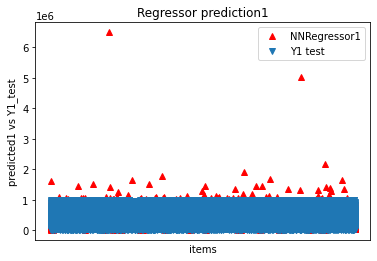

In [198]:
plt.figure()
plt.plot(prediction1, 'r^', label='NNRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

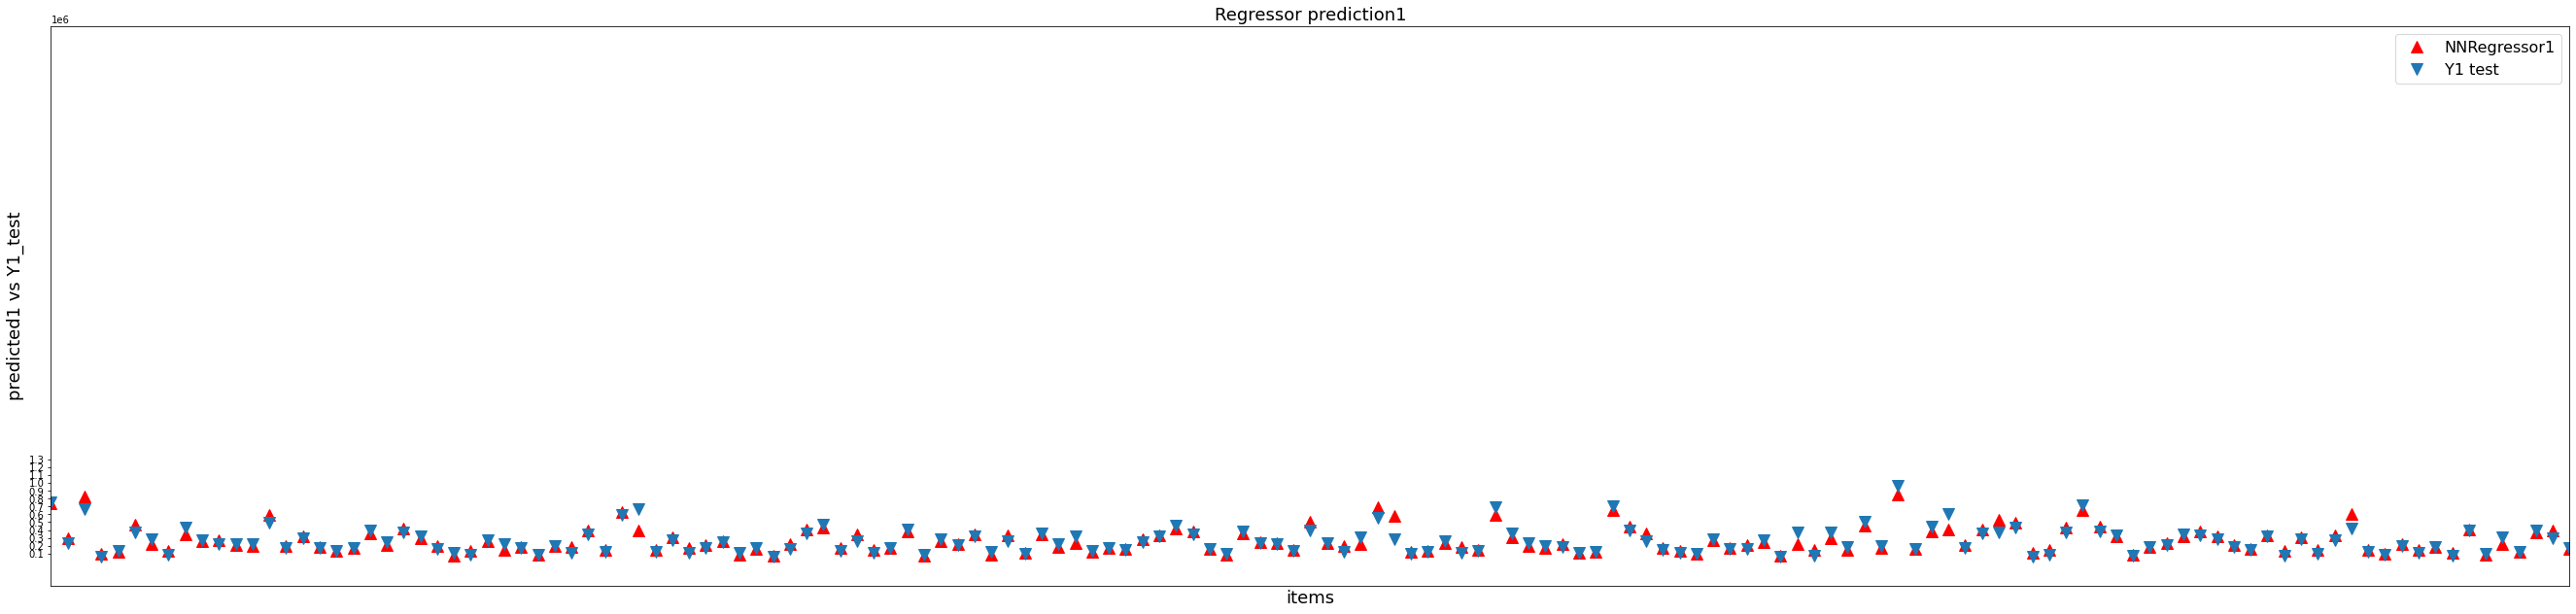

In [199]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='NNRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [200]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [201]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

67523.73828513939

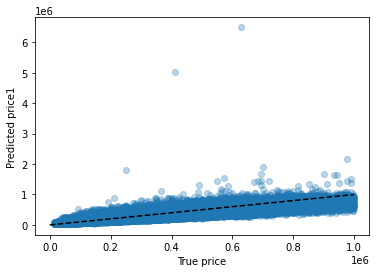

In [202]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [203]:
#test data has several very bad predictions:
#test prediction_90pc_df1
prediction_over90pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=90) ] 
within_90pc_error1=100*prediction_over90pc_df1.shape[0]/prediction_df1.shape[0]
print('Test predictions where error is 90% or more :' + str(within_90pc_error1) + ' %')

Test predictions where error is 90% or more :1.6610140859712044 %


In [204]:
prediction_over90pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
80,3.0,1.0,1.0,76.000000,134.621048,0.495720,54.000004,11.6,10.599999,211041.671875,358500.031250,21.0,7.249100e+08,2.631361e+10,1.648985e+10,51.524288,-0.064410,285000.0,584176.500000,-299176.500000,8.950658e+10,299176.500468,7249100_263136051_164898488,104.974211
105,3.0,2.0,2.0,2.000000,55.057816,4.239952,45.000000,7.7,7.200000,63999.996094,50904.164062,16.0,4.216007e+10,1.981766e+10,3.049486e+10,55.215096,-1.544240,66000.0,140823.968750,-74823.968750,5.598626e+09,74823.968780,421600707_198176645_304948613,113.369650
133,1.0,2.0,2.0,6.000000,113.758209,0.689592,31.000000,8.9,7.900000,81250.000000,71750.000000,7.0,2.609621e+10,3.449381e+10,2.490197e+10,50.478065,-3.514624,71000.0,135570.875000,-64570.875000,4.169398e+09,64570.875912,260962058_344938086_249019679,90.944896
256,3.0,2.0,3.0,1.000000,65.735397,0.522050,12.000000,10.0,9.300000,82333.328125,103200.000000,8.0,3.483087e+10,8.934055e+09,2.021433e+10,54.224072,-2.769847,132000.0,260741.515625,-128741.515625,1.657438e+10,128741.516163,348308726_89340549_202143273,97.531452
392,3.0,2.0,2.0,5.000000,135.785126,1.806350,47.000000,9.7,8.900000,28333.333984,21500.000000,10.0,3.589852e+10,1.497427e+10,2.489078e+10,54.680851,-1.208408,18000.0,61984.007812,-43984.007812,1.934593e+09,43984.007275,358985196_149742715_248907817,244.355596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307445,3.0,2.0,3.0,6.000000,126.554932,0.425053,33.000000,11.7,9.599999,22077.082031,26166.667969,24.0,3.685216e+10,1.530368e+10,2.551262e+10,54.751301,-1.347036,41250.0,91694.820312,-50444.820312,2.544680e+09,50444.820705,368521626_153036790_255126180,122.290474
307454,3.0,2.0,2.0,15.999999,115.291130,1.120267,27.000002,11.4,9.799999,39625.000000,41833.332031,24.0,3.862241e+10,1.678727e+10,2.717952e+10,54.907124,-1.403753,57000.0,108586.992188,-51586.992188,2.661218e+09,51586.992469,386224087_167872748_271795220,90.503496
307732,2.0,2.0,2.0,2.000000,104.259148,1.904700,47.000000,7.1,6.600000,45333.332031,43666.667969,24.0,2.131049e+10,9.852617e+09,1.268620e+10,53.394321,-0.770929,35000.0,84213.234375,-49213.234375,2.421943e+09,49213.235293,213104947_98526167_126862029,140.609244
307766,2.0,2.0,3.0,25.000000,64.195885,1.227904,38.000000,7.8,7.700000,53416.664062,51583.332031,17.0,2.777701e+10,5.156548e+09,1.499936e+10,53.825603,-1.727407,67500.0,133489.156250,-65989.156250,4.354569e+09,65989.155958,277770076_51565481_149993574,97.761713


In [205]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

66418.98925411346

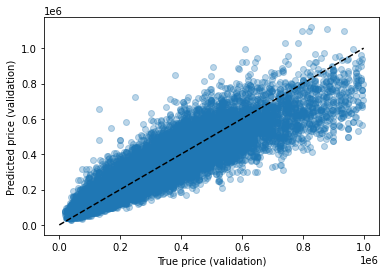

In [206]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()

In [208]:
#validation data has several very bad predictions:
#validation prediction_90pc_df1
prediction_over90pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=90) ] 
within_90pc_error1_val=100*prediction_over90pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 90% or more :' + str(within_90pc_error1_val) + ' %')

Predictions where error is 90% or more :1.7021766008223354 %


In [209]:
prediction_over90pc_df1_val

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,error_perc
17,1.0,1.0,1.0,18.0,88.726289,0.888273,12.0,11.8,11.2,90208.33333,75187.50000,26.0,3.982967e+10,1.783974e+10,2.833047e+10,55.013802,-1.439469,49500,100873.851562,51373.9,2.63927e+09,51373.9,398296690_178397430_283304660,103.786
160,1.0,1.0,1.0,6.0,75.156867,0.453190,23.0,9.9,8.3,122000.00000,108750.00000,26.0,6.681220e+09,1.934935e+10,9.718739e+09,52.018293,-0.693980,58500,133752.281250,75252.3,5.66291e+09,75252.3,66812200_193493480_97187390,128.636
198,1.0,1.0,2.0,5.0,82.711422,0.523760,24.0,9.8,8.8,36350.00000,38916.66667,26.0,4.112260e+10,1.886020e+10,2.948362e+10,55.122615,-1.519202,31000,60964.511719,29964.5,8.97872e+08,29964.5,411226050_188601990_294836150,96.6597
215,1.0,1.0,1.0,41.0,87.548348,1.004739,50.0,0.4,0.4,225625.00000,240281.25000,26.0,6.058120e+08,2.573092e+10,1.561322e+10,51.511629,-0.255135,140000,308060.750000,168061,2.82444e+10,168061,6058120_257309160_156132240,120.043
245,1.0,1.0,1.0,16.0,90.695811,0.811408,54.0,9.0,5.7,50000.00000,50500.00000,26.0,3.449683e+10,1.330220e+10,2.323720e+10,54.539786,-1.303136,32000,69794.726562,37794.7,1.42844e+09,37794.7,344968260_133022010_232371960,118.109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34683,5.0,2.0,4.0,23.0,106.495958,0.424742,72.0,8.2,7.6,57000.00000,56666.66667,26.0,2.850524e+10,5.328915e+09,1.262060e+10,53.386753,-3.039939,162000,354564.125000,192564,3.70809e+10,192564,285052449_53289150_126205970,118.867
34732,5.0,2.0,2.0,14.0,98.318898,1.489947,60.0,11.8,9.5,41666.66667,39000.00000,26.0,3.473978e+10,1.344772e+10,2.343772e+10,54.559854,-1.320500,89000,187912.406250,98912.4,9.78366e+09,98912.4,347397750_134477230_234377160,111.138
34749,5.0,1.0,2.0,10.0,56.960515,1.130315,33.0,8.4,6.8,50500.00000,58325.00000,26.0,2.939118e+10,3.483122e+09,1.483113e+10,53.779837,-2.410257,113500,222924.359375,109424,1.19737e+10,109424,293911850_34831220_148311340,96.4091
34762,5.0,2.0,4.0,9.0,63.496471,2.380537,21.0,10.1,9.0,49125.00000,55000.00000,26.0,3.268831e+10,6.852067e+09,1.732730e+10,53.883061,-3.039913,160000,370404.437500,210404,4.427e+10,210404,326883130_68520670_173273010,131.503
